<a href="https://colab.research.google.com/github/EwoutBergsma/docs/blob/master/Smart_System_Project_simulating_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1, create logistic growth


$P_n = P_{n-1} + r (1- \frac{P_{n-1}}{c}) * P_{n-1}$

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

In [ ]:
def create_logistic_curve(time, carrying_capacity = 1, growth_rate = 0.1, initial_population = 0.01):
  population = [initial_population]
  time = time[:-1]  # [:-1] as first timestep is done at line above

  # Normalizing parameters base on a time range of (0-1)
  growth_rate = growth_rate / time[-1]
  initial_population = initial_population / time[-1]

  # If growth_rate is a list it is used as dynamic growth_rate
  if type(growth_rate) is list or type(growth_rate) is np.ndarray:
    for t, g in zip(time, growth_rate):
      population.append(population[-1] + g * (1 - (population[-1]/carrying_capacity)) * population[-1])
  # Otherwise a static growth_rate is assumed
  else:
    for t in time:
      population.append(population[-1] + growth_rate * (1 - (population[-1]/carrying_capacity)) * population[-1])


  return population

In [ ]:
# Generic plotting function
def plot_curve(subplot, time, data, title, xlabel, ylabel):
  plt.subplot(subplot)
  plt.plot(time, data)
  plt.title(title)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)

In [ ]:
# Time range we will use throughout this notebook, it's 14 days, with a timestep each minute
days = 14
minutes_per_day = 1440
time = np.arange(0, days*minutes_per_day) / minutes_per_day

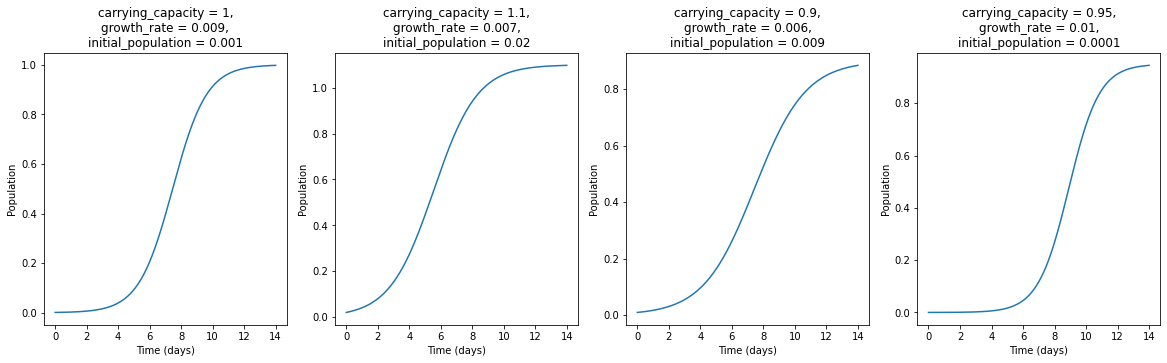

In [ ]:
plt.figure(figsize=(20,5))
plot_curve(141, time, create_logistic_curve(time, 1, 0.009, 0.001), f"carrying_capacity = {1},\ngrowth_rate = {0.009},\ninitial_population = {0.001}", "Time (days)", "Population")
plot_curve(142, time, create_logistic_curve(time, 1.1, 0.007, 0.02), f"carrying_capacity = {1.1},\ngrowth_rate = {0.007},\ninitial_population = {0.02}", "Time (days)", "Population")
plot_curve(143, time, create_logistic_curve(time, 0.9, 0.006, 0.009), f"carrying_capacity = {0.9},\ngrowth_rate = {0.006},\ninitial_population = {0.009}", "Time (days)", "Population")
plot_curve(144, time, create_logistic_curve(time, 0.95, 0.01, 0.0001), f"carrying_capacity = {0.95},\ngrowth_rate = {0.01},\ninitial_population = {0.0001}", "Time (days)", "Population")
plt.show()

# Step 2, add noise to logistic growth

In [ ]:
def create_noise(length, standard_deviation):
  # return np.random.normal(loc=0.0, scale=standard_deviation, size=length)
  return np.random.uniform(low=-standard_deviation, high=standard_deviation, size=length)

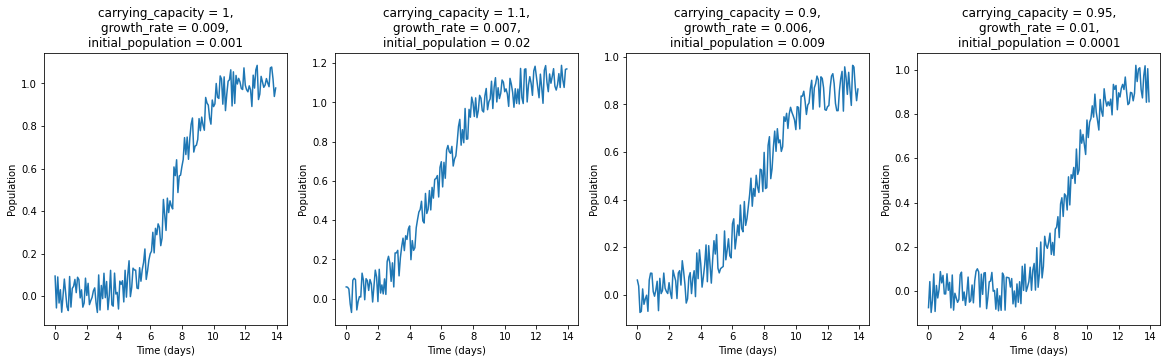

In [ ]:
plt.figure(figsize=(20,5))
plot_curve(141, time[::120], create_logistic_curve(time, 1, 0.009, 0.001)[::120] + create_noise(len(time), 0.1)[::120], f"carrying_capacity = {1},\ngrowth_rate = {0.009},\ninitial_population = {0.001}", "Time (days)", "Population")
plot_curve(142, time[::120], create_logistic_curve(time, 1.1, 0.007, 0.02)[::120] + create_noise(len(time), 0.1)[::120], f"carrying_capacity = {1.1},\ngrowth_rate = {0.007},\ninitial_population = {0.02}", "Time (days)", "Population")
plot_curve(143, time[::120], create_logistic_curve(time, 0.9, 0.006, 0.009)[::120] + create_noise(len(time), 0.1)[::120], f"carrying_capacity = {0.9},\ngrowth_rate = {0.006},\ninitial_population = {0.009}", "Time (days)", "Population")
plot_curve(144, time[::120], create_logistic_curve(time, 0.95, 0.01, 0.0001)[::120] + create_noise(len(time), 0.1)[::120], f"carrying_capacity = {0.95},\ngrowth_rate = {0.01},\ninitial_population = {0.0001}", "Time (days)", "Population")
plt.show()

# Step 3, fit logistic growth curve to noisy data

Source:
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html


In [ ]:
# Ground truth model parameters we will consider for modelling
carrying_capacity = 1
growth_rate = 0.009
initial_population = 0.001

# Normally distributed noise we will consider for modelling
standard_deviation = 0.15

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in double_scalars
  app.launch_new_instance()


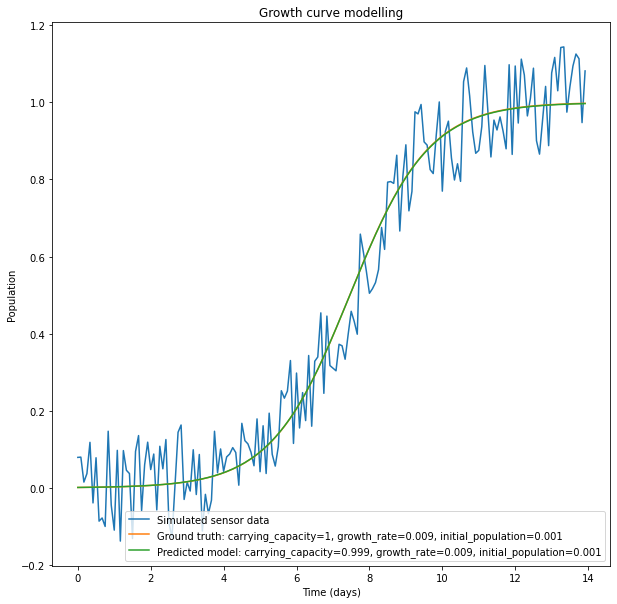

In [ ]:
# The data
y_truth = create_logistic_curve(time, carrying_capacity, growth_rate, initial_population)
y_noise = y_truth + create_noise(len(time), standard_deviation)

# Fitting to create predicted model
popt, pcov = curve_fit(create_logistic_curve, time, y_noise, maxfev=-1)
y_predicted = create_logistic_curve(time, *popt)

# Plot 'em
plt.figure(figsize=(10,10))
plt.plot(time[::120], y_noise[::120], label="Simulated sensor data")
plt.plot(time[::120], y_truth[::120], label=f"Ground truth: carrying_capacity={carrying_capacity}, growth_rate={growth_rate}, initial_population={initial_population}")
plt.plot(time[::120], y_predicted[::120], label=f'Predicted model: carrying_capacity={popt[0]:.3f}, growth_rate={popt[1]:.3f}, initial_population={popt[2]:.3f}')
# plt.plot(time, y_predicted, label='Predicted model: %5.3f, %5.3f, %5.3f' % tuple(popt))
plt.legend()
plt.title("Growth curve modelling")
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.show()

# Step 4, create new subset of data, estimate its position on above model

In [ ]:
def find_position_subset_on_model(model, subset):
  best_MSE = np.inf
  best_starting_position = -1
  
  for index in range(0, len(model) - len(subset)):
    evaluated_subset_model = model[index:index+len(subset)]
    MSE = np.mean((np.array(evaluated_subset_model) - np.array(subset))**2)
    if MSE < best_MSE:
      best_MSE = MSE
      best_starting_position = index

  return best_starting_position, best_MSE

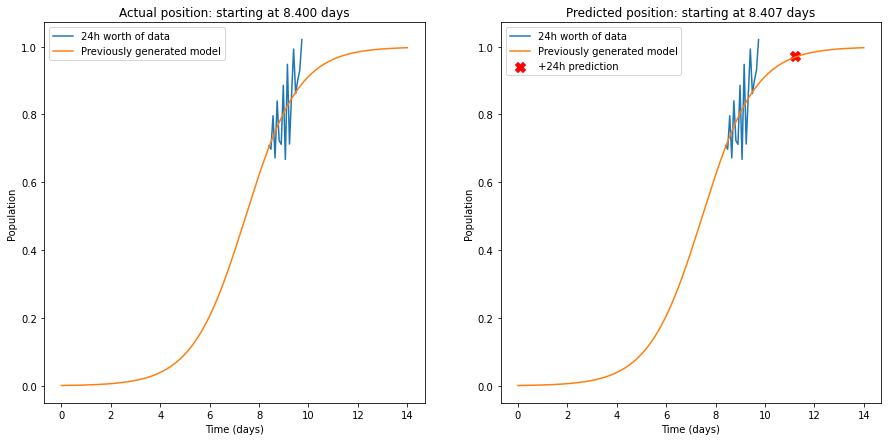

In [ ]:
subset = [int(0.6*len(time)), int(0.7*len(time))]  # The subset of data (whole set is considered to be the full growth curve data)

new_y_truth = create_logistic_curve(time, carrying_capacity, growth_rate, initial_population)

subsetted_new_y_noise = y_truth[subset[0]:subset[1]] + create_noise(len(time), standard_deviation)[subset[0]:subset[1]]
subsetted_time = time[subset[0]:subset[1]]

position, MSE = find_position_subset_on_model(y_predicted, subsetted_new_y_noise)
predicted_time = time[position : position + len(subsetted_new_y_noise)]

plt.figure(figsize=(15,7))

plt.subplot(121)
plt.title(f"Actual position: starting at {subsetted_time[0]:.3f} days")
plt.plot(subsetted_time[::120], subsetted_new_y_noise[::120], label="24h worth of data")
plt.plot(time, y_predicted, label=f'Previously generated model')
plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()

plt.subplot(122)
plt.title(f"Predicted position: starting at {predicted_time[0]:.3f} days")
plt.plot(predicted_time[::120], subsetted_new_y_noise[::120], label="24h worth of data")
plt.plot(time, y_predicted, label=f'Previously generated model')

future_time = 2* predicted_time[-1] - predicted_time[0]
plt.scatter(future_time, 0.972, label="+24h prediction", color="r", s=100, marker="X")  # TODO: automate future_population

plt.xlabel("Time (days)")
plt.ylabel("Population")
plt.legend()

plt.show()

TODO: add prediction in the mix

# Step 5, create dynamic growth rate

0.005 0.015


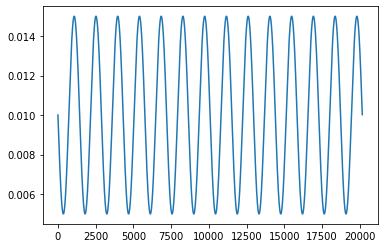

In [ ]:
# Creating a list of varying growth rate
Fs = len(time)
f = 14
n_samples = len(time)
dynamic_growth_rates = np.sin(2 * np.pi * f * time*minutes_per_day / Fs) * -0.005 + 0.01

print(min(dynamic_growth_rates), max(dynamic_growth_rates))

plt.plot(dynamic_growth_rates)
plt.show()

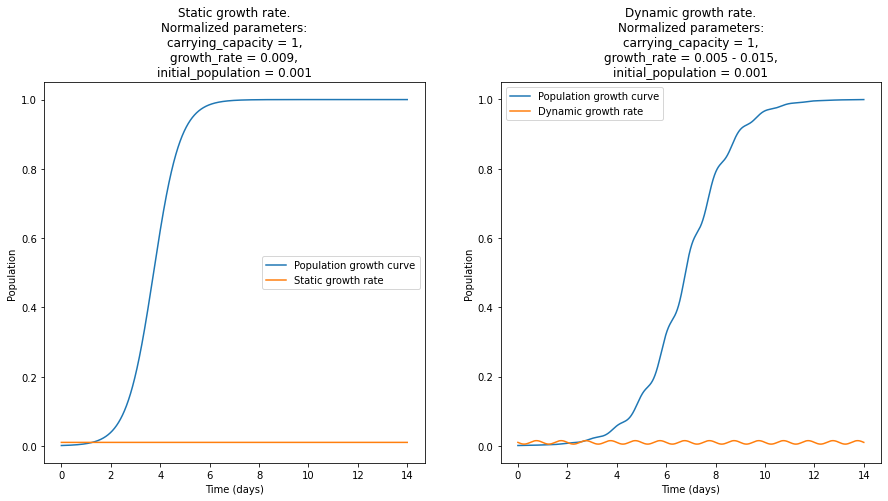

In [ ]:
plt.figure(figsize=(15,7))
plot_curve(121, time, create_logistic_curve(time, 1, 0.018, 0.001), f"Static growth rate.\nNormalized parameters:\ncarrying_capacity = {1},\ngrowth_rate = {0.009},\ninitial_population = {0.001}", "Time (days)", "Population")
plt.plot(time, [0.01] * len(time))
plt.legend(["Population growth curve","Static growth rate"])
plot_curve(122, time, create_logistic_curve(time, 1, dynamic_growth_rates, 0.001), f"Dynamic growth rate.\nNormalized parameters:\ncarrying_capacity = {1},\ngrowth_rate = {min(dynamic_growth_rates):.3f} - {max(dynamic_growth_rates):.3f},\ninitial_population = {0.001}", "Time (days)", "Population")
plt.plot(time, dynamic_growth_rates)
plt.legend(["Population growth curve","Dynamic growth rate"])
plt.show()